# Gaussian Mixture Model 1D
Hasti Hojabr \
ID : 97216040\
Proffesor: Marzie Farhang\
Course: Statics, Probability and Data Analysis @ Shahid Beheshti University 
Date: June 8,2022

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from IPython.display import display, HTML
warnings.filterwarnings("ignore")

In [7]:
from matplotlib.pyplot import cm

### 1.1 Expectation Maximization Algorithm  

In [8]:
def GMM_1D(X,k,iterations,check): #array of data, numbers of clusters, number of iterations

    def Gaussian_distribution(x,mean,var):
        return np.exp(-(x-mean)**2/2/var)/np.sqrt(2*np.pi*var)
    
    def Gaussian_plot(mean_list,var_list,data,pi_list):
        
        x = np.linspace(np.min(data),np.max(data),100)
        c = cm.winter(np.linspace(0, 1, len(mean_list)))
        for mean, var,pi,color in zip(mean_list,var_list,pi_list,c):
            P = Gaussian_distribution(x,mean,var)
            plt.plot(x, P*pi,color=color,lw=2)
            
    def Expectation(X,means,variances): 
        r = [] ; r_norm=[]
        for i in range(k): r.append(Gaussian_distribution(X, means[i],variances[i]))
        
        r = np.array(r)  
        for j in range(k): r_norm.append((r[j])/(np.sum([r[i] for i in range(k)], axis=0)))
        
        return np.array(r_norm),np.sum([r[i] for i in range(k)], axis=0)  #responsibility,likelihood
    
    def Maximization(r,means,variances,pi): 
        for i in range(k):
            Nk           = np.sum(r[i])
            pi[i]        = Nk/len(X)                               #pi = Nk/N where Nk = sum (r_nk)
            means[i]     = np.sum(r[i]*X)/Nk                       #mean = sum (rx)/Nk
            variances[i] = np.sum(r[i]*(X - means[i])**2)/Nk       #var = sum(r(x-mean)^2)/Nk
        return means,variances,pi
    
    
    #Initialize the hidden variables
    pi = np.repeat(1/k,k) 
    means = np.random.uniform(1,np.max(X),k) ; variances = np.random.uniform(size=k)
    for i in range(len(variances)):
        if variances[i]==0: variances[i]+=0.01

    log_likelihood = np.zeros(iterations)
    
    axis=1 ; fig = plt.figure(figsize=(18, 8))
    for iterr in range(iterations):

        r,likelihood       = Expectation(X,means,variances)       #E step
        means,variances,pi = Maximization(r,means,variances,pi)   #M step
        
        log_likelihood[iterr] = np.log(np.sum(likelihood))
        
        if iterr in [0,2,(iterations-1)//2,iterations-1]: 
            
            ax =  fig.add_subplot(2, 2, axis )
            plt.title('Iteration {}/{}'.format(iterr,iterations+1))
            Gaussian_plot(means,variances,X,pi)
            plt.hist(X,bins=50,density=True,color='powderblue',alpha=0.4)
            plt.scatter(X, np.zeros(len(X)), color='k', s=30, marker='|') 
            axis+=1
    plt.show()

    return means,variances,log_likelihood,pi

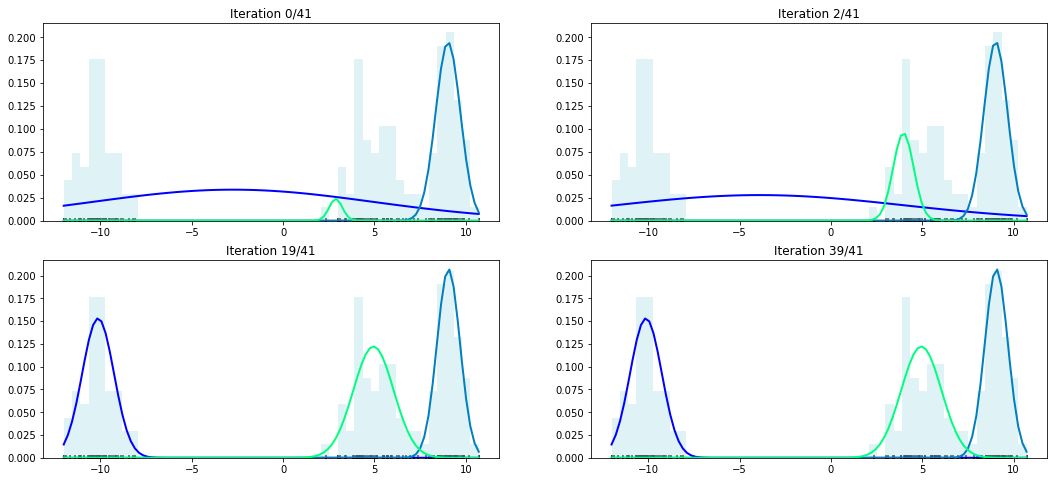

In [9]:
x1 = np.random.normal(-10, 1, 50) ; x2 = np.random.normal(5, 1, 50) ; x3 = np.random.normal(9, 1, 50)
X = np.array(list(x1) + list(x2) + list(x3))
means,variances,lh,pis = GMM_1D(X,3,40,5)

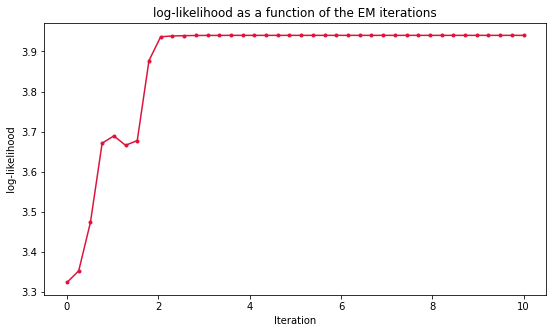

In [10]:
fig = plt.figure(figsize=(9, 5))
x=np.linspace(0,10,len(lh))
plt.plot(x,lh,color='crimson',marker='.')
plt.xlabel('Iteration') ; plt.ylabel(' log-likelihood ')
plt.title('log-likelihood as a function of the EM iterations')
plt.show()

### 1.2 Using Sklearn

In [11]:
from sklearn.mixture import GaussianMixture  

def GMM_sklearn_1d(X,k,iterations):
    
    def Gaussian_distribution(x,mean,var):
        return np.exp(-(x-mean)**2/2/var)/np.sqrt(2*np.pi*var)
    
    def Gaussian_plot(mean_list,var_list,data,pi_list):
        
        x = np.linspace(np.min(data),np.max(data),100)
        c = cm.winter(np.linspace(0, 1, len(mean_list)))
        for mean, var,pi,color in zip(mean_list,var_list,pi_list,c):
            P = Gaussian_distribution(x,mean,var)
            plt.plot(x, P*pi,color=color,lw=2)

    x = X.reshape(len(X),1)

    GMM = GaussianMixture(n_components = k, max_iter=iterations, random_state=10, covariance_type = 'full')

    means = GMM.fit(x).means_  
    covs  = GMM.fit(x).covariances_
    pi    = GMM.fit(x).weights_
    mean  = [means[i][0] for i in range(len(means))] ; cov = [covs[i][0][0] for i in range(len(covs))]
        
    fig = plt.figure(figsize=(9, 5))
    Gaussian_plot(mean,cov,X,pi)
    plt.hist(X,bins=50,density=True,color='powderblue',alpha=0.4)
    plt.scatter(X, np.zeros(len(X)), color='k', s=30, marker='|')
    plt.show()
    return mean,covs,pi


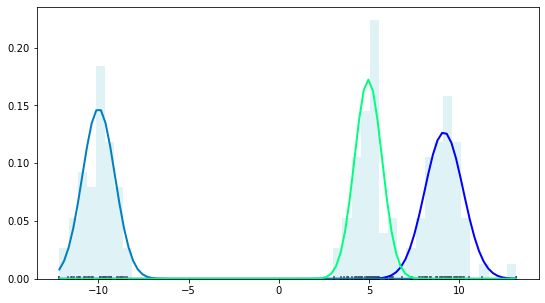

In [12]:
x1 = np.random.normal(-10, 1, 50) ; x2 = np.random.normal(5, 1, 50) ; x3 = np.random.normal(9, 1, 50)
X = np.array(list(x1) + list(x2) + list(x3))

mean,covs,pi = GMM_sklearn_1d(X,3,1000)

In [13]:
from sklearn.mixture import GaussianMixture  

def BIC_AIC(X,max_k):

    X= X.reshape(len(X),1) ; GMM = []
    for k in range(1,max_k+1):
        GMM.append(GaussianMixture(n_components = k, max_iter=10000, random_state=10, covariance_type='full').fit(X)) 
    
    BIC=[] ; AIC=[]
    for gmm in GMM:
        BIC.append(gmm.bic(X))
        AIC.append(gmm.aic(X))
    
    fig = plt.figure(figsize=(9, 5))
    plt.plot(range(1,max_k+1),BIC,color='darkblue',marker='.',label='BIC',lw=2)
    plt.plot(range(1,max_k+1),AIC,color='crimson',marker='.',label='AIC',lw=2)
    plt.xlabel('Number of Clusters ')
    plt.title('BIC & AIC')
    plt.show()
    
    optimal_BIC = np.argmin(np.array(BIC))+1 ; optimal_AIC = np.argmin(np.array(BIC))+1
    
    print('The optimal number of clusters is {} using BIC.'.format(optimal_BIC))
    print('The optimal number of clusters is {} using AIC.'.format(optimal_AIC))


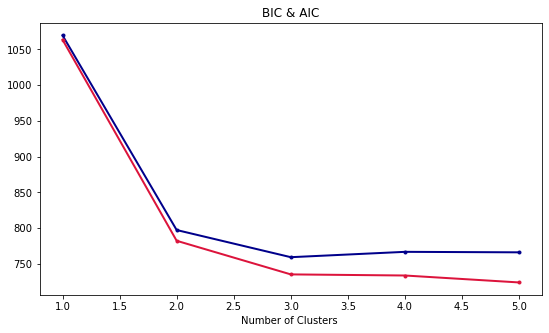

The optimal number of clusters is 3 using BIC.
The optimal number of clusters is 3 using AIC.


In [14]:
BIC_AIC(X,5)